# <center> Projet : Domain adaptation entre MNIST et SVHN

### <center> Auteur : Jérôme Dauba, MS IA



## Objectif :

L'objectif de ce projet est de travailler sur le sujet d'adaptation de domaine : en partant d'un classifieur entrainé sur SVHN, comment le transformer pour classifier avec une grande précision des images de MNIST de manière non supervisée ?

## Méthodologie :
Dans ce rapport, nous essaierons d'utiliser quelques méthodes d'apprentissage non supervisé (clustering, auto-encodeurs), puis nous nous inspirerons du papier https://arxiv.org/pdf/2001.02950.pdf pour résoudre cette problématique par l'utilisation de Conditional-GAN en ayant une accuracy finale de 96%.

## Plan du rapport :
- Importation des librairies utiles
- Importation et visualisation des datasets MNIST et SVHN
- Entrainement d'un classifieur sur SVHN
- Partie 1 : essais de clustering et Auto Encoders
- Partie 2 : Amélioration du classifieur avec un conditional GAN 
Après avoir visualisé les données issues des 2 datasets, nous entrainerons tout d'abord un classifieur (CNN) sur le dataset SVHN.



Importation des librairies :

In [ ]:
#General import :
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import random
from numpy import load
from random import shuffle
from math import *
import os

#Visualization :
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn utils, metrics :
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Sklearn clustering :
from sklearn.cluster import KMeans

#Dimension reduction :
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Working with images :
import cv2
from PIL import Image

#Pytorch specific :
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
from torch.autograd import Variable
from torchvision import transforms, utils
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Notebook specific :
from tqdm.notebook import tqdm
from IPython.display import clear_output
# clear_output()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Définition de fonctions utiles :

In [ ]:
def show_mnist(tensor):
  tensor = tensor*0.5 + 0.5 # Dernormalize
  array = np.transpose(np.array(tensor), (1,2,0)).reshape(32,32)
  plt.imshow(array, cmap='gray')

def show_svhn(tensor):
  #tensor[0,:,:] = tensor[0,:,:]*0.2 + 0.438
  #tensor[1,:,:] = tensor[1,:,:]*0.2 + 0.444
  #tensor[2,:,:] = tensor[2,:,:]*0.197 + 0.473

  tensor = tensor*0.2 + 0.44

  array = np.transpose(np.array(tensor), (1,2,0)).reshape(32,32)
  plt.imshow(array, cmap='gray')

def tensor3D(tensor):
  tensor_3d = torch.zeros((batch_size,32,32))
  tensor_3d[:,0,:,:] = tensor.squeeze()
  tensor_3d[:,1,:,:] = tensor.squeeze()
  tensor_3d[:,2,:,:] = tensor.squeeze()
  return(tensor_3d)



def compute_precision(outputs, labels):
  liste_true, liste_pred = [], []
  for i, output in enumerate(outputs):
    label_predicted = np.argmax(output.cpu().detach().numpy())
    liste_pred.append(label_predicted)

    label_true = labels[i].item()
    liste_true.append(label_true)

  mean = (np.array(liste_true) == np.array(liste_pred)).mean()
  return mean

### Importation du Datasets MNIST :

On resize les images MNIST de 28x28 en 32x32 pour matcher la dimension des images de SVHN (le plus grand est le mieux) :

In [ ]:
# MNIST :
batch_size = 64

train_loader_MNIST = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((32,32)),
                               transforms.Normalize((0.5,), (0.5,))
                             ])),
  batch_size=batch_size, shuffle=True, drop_last=True)

test_loader_MNIST = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((32,32)),
                               transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size, shuffle=True, drop_last=True)

clear_output()

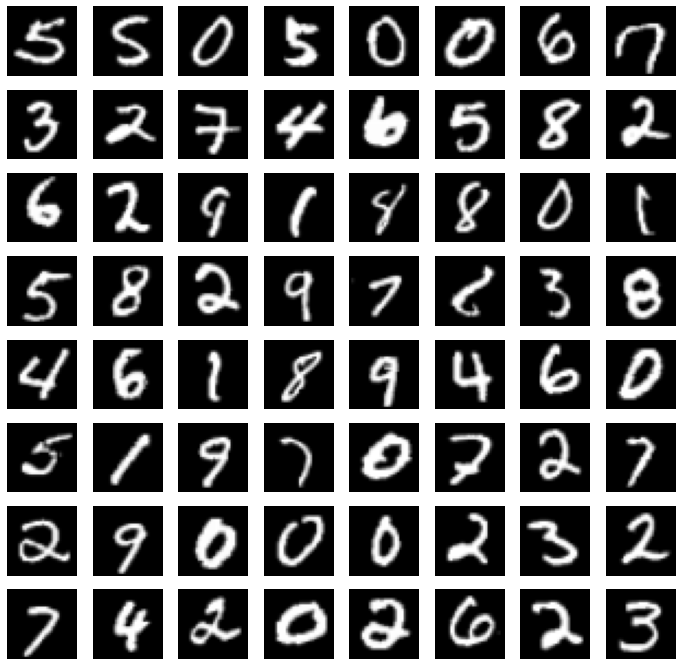

In [ ]:
# On affiche un batch d'images de MNIST :
for data in train_loader_MNIST :
  inputs, label = data
  plt.figure(figsize=(12,12))
  for i,image in enumerate(inputs):
    plt.subplot(8,8,i+1)
    show_mnist(image)
    plt.axis('Off')
  break

### Importation de SVHN :

Je crée ici un Dataloader de SVHN avec une pipeline de transformation. Cette dernière à pour objectif de transformer les images en tenseur, de les resize, les normaliser, de les convertir en grayscale mais également d'appliquer un peu de data augmentation en modifiant aléatoirement la luminosité, le contraste etc...

Ainsi, notre classifieur "C" sur SVHN n'en sera que plus robuste.

Par ailleurs, afin d'entrainer efficacement le classifieur C sur SVHN, j'ai découpé le dataset en 2 parties : train et validation, à l'aide de samplers :

In [ ]:
# SVHN :
batch_size = 64

transform_SVHN = torchvision.transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize((32,32)),
                               transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.3, hue=0.1), # Data Augmentation !
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Normalize((0.44), (0.2))
                             ])


SVHN_dataset = torchvision.datasets.SVHN('/files/', split='train', download=True,
                             transform=transform_SVHN)

validation_split = 0.1
dataset_size = len(SVHN_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader_SVHN = torch.utils.data.DataLoader(SVHN_dataset, batch_size=batch_size, sampler = train_sampler, drop_last=True)


test_loader_SVHN = torch.utils.data.DataLoader(SVHN_dataset, batch_size=batch_size, sampler = valid_sampler, drop_last=True)

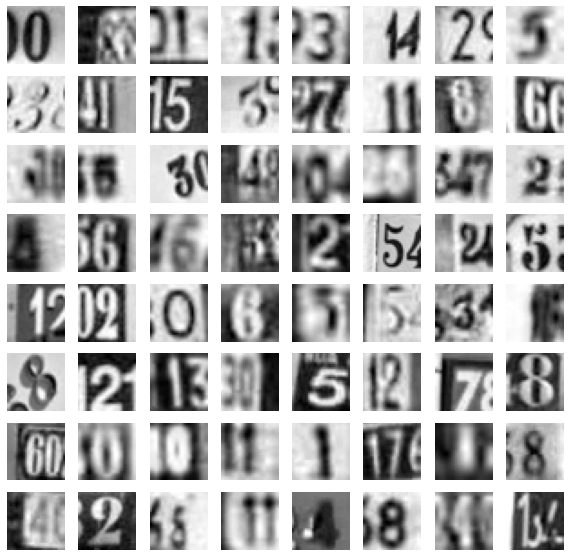

In [ ]:
# On affiche un batch d'images de SVHN  :
for data in train_loader_SVHN :
  inputs, label = data
  plt.figure(figsize=(10,10))
  for i,image in enumerate(inputs):
    plt.subplot(8,8,i+1)
    show_svhn(image)
    plt.axis('Off')
  break

## Definition du classifieur :

On définit ci-dessous l'architecture du classifieur (CNN) :

In [ ]:
""" Classifieur de type CNN """
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3) # On prend en entrée des images grayscale
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=None)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.dropout(x)
        #print("Après conv", x.shape)
        x = x.view(batch_size, -1)
        #print("Après view", x.shape)
        x = F.relu(self.fc1(x))
        #print("Après fc1", x.shape)
        x = F.relu(self.fc2(x))
        #print("Après fc2", x.shape)
        x = torch.sigmoid(self.fc3(x))
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = Net().to(device)

cuda:0


In [ ]:
torch.cuda.empty_cache()

#Criterion and optimizer :
lr = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

## Entrainement du classifieur C sur SVHN :

[1,   100] loss: 224.459 , Val loss: 224.56, Train precision: 0.31, Val precision: 0.22
[1,   200] loss: 208.346 , Val loss: 208.13, Train precision: 0.47, Val precision: 0.64
[1,   300] loss: 188.685 , Val loss: 188.05, Train precision: 0.73, Val precision: 0.70
[1,   400] loss: 178.840 , Val loss: 179.06, Train precision: 0.69, Val precision: 0.66
[1,   500] loss: 173.377 , Val loss: 173.81, Train precision: 0.73, Val precision: 0.70
[1,   600] loss: 170.586 , Val loss: 169.97, Train precision: 0.80, Val precision: 0.75
[1,   700] loss: 168.103 , Val loss: 167.56, Train precision: 0.69, Val precision: 0.77
[1,   800] loss: 166.025 , Val loss: 165.75, Train precision: 0.81, Val precision: 0.78
[1,   900] loss: 165.942 , Val loss: 165.04, Train precision: 0.75, Val precision: 0.91
[1,  1000] loss: 164.495 , Val loss: 164.20, Train precision: 0.80, Val precision: 0.83



[2,   100] loss: 162.558 , Val loss: 163.57, Train precision: 0.84, Val precision: 0.80
[2,   200] loss: 162.631 , Val loss: 163.27, Train precision: 0.88, Val precision: 0.88
[2,   300] loss: 161.580 , Val loss: 162.29, Train precision: 0.86, Val precision: 0.89
[2,   400] loss: 161.606 , Val loss: 161.66, Train precision: 0.88, Val precision: 0.88
[2,   500] loss: 161.493 , Val loss: 161.59, Train precision: 0.83, Val precision: 0.84
[2,   600] loss: 160.840 , Val loss: 160.82, Train precision: 0.81, Val precision: 0.86
[2,   700] loss: 160.512 , Val loss: 160.73, Train precision: 0.86, Val precision: 0.86
[2,   800] loss: 160.348 , Val loss: 160.09, Train precision: 0.80, Val precision: 0.83
[2,   900] loss: 159.919 , Val loss: 160.46, Train precision: 0.94, Val precision: 0.83
[2,  1000] loss: 159.757 , Val loss: 159.34, Train precision: 0.92, Val precision: 0.86



[3,   100] loss: 158.424 , Val loss: 159.53, Train precision: 0.81, Val precision: 0.80
[3,   200] loss: 159.219 , Val loss: 159.15, Train precision: 0.88, Val precision: 0.80
[3,   300] loss: 158.643 , Val loss: 159.61, Train precision: 0.86, Val precision: 0.81
[3,   400] loss: 158.394 , Val loss: 159.06, Train precision: 0.84, Val precision: 0.94
[3,   500] loss: 158.598 , Val loss: 158.78, Train precision: 0.89, Val precision: 0.83
[3,   600] loss: 158.085 , Val loss: 159.16, Train precision: 0.84, Val precision: 0.84
[3,   700] loss: 158.140 , Val loss: 158.75, Train precision: 0.88, Val precision: 0.81
[3,   800] loss: 157.863 , Val loss: 158.28, Train precision: 0.84, Val precision: 0.92
[3,   900] loss: 158.151 , Val loss: 158.45, Train precision: 0.89, Val precision: 0.88
[3,  1000] loss: 157.533 , Val loss: 158.22, Train precision: 0.91, Val precision: 0.84



[4,   100] loss: 156.797 , Val loss: 158.50, Train precision: 0.94, Val precision: 0.83
[4,   200] loss: 157.177 , Val loss: 158.08, Train precision: 0.89, Val precision: 0.84
[4,   300] loss: 157.366 , Val loss: 157.71, Train precision: 0.89, Val precision: 0.81
[4,   400] loss: 156.495 , Val loss: 157.92, Train precision: 0.92, Val precision: 0.83
[4,   500] loss: 156.945 , Val loss: 157.54, Train precision: 0.94, Val precision: 0.91
[4,   600] loss: 156.907 , Val loss: 157.23, Train precision: 0.78, Val precision: 0.84
[4,   700] loss: 157.328 , Val loss: 157.50, Train precision: 0.91, Val precision: 0.89
[4,   800] loss: 156.597 , Val loss: 157.25, Train precision: 0.95, Val precision: 0.92
[4,   900] loss: 156.753 , Val loss: 156.72, Train precision: 0.92, Val precision: 0.89
[4,  1000] loss: 156.921 , Val loss: 157.55, Train precision: 0.88, Val precision: 0.89


Finished Training


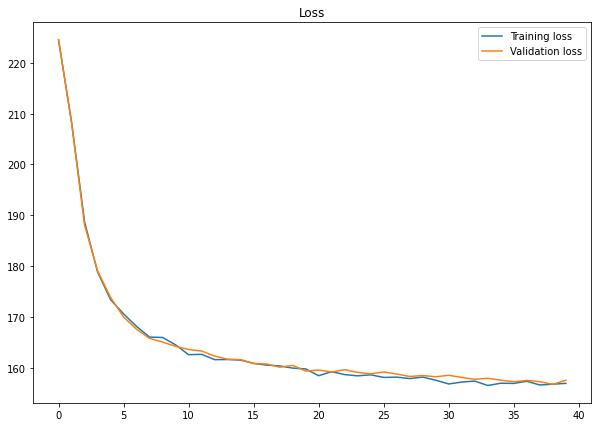


 Plotting average precision :


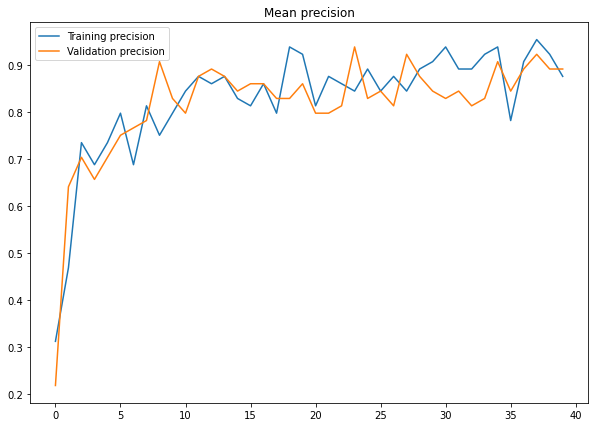

In [ ]:
#Training :
net.train()
liste_loss, liste_loss_val = [], []
precision_train, precision_val = [], []

epochs = 4
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    val_loss = 0.0
    i = 0
    for data_train in tqdm(train_loader_SVHN):
        # For the training set :
        inputs_train, labels_train = data_train
        inputs_train, labels_train = inputs_train.to(device), labels_train.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_train = net(inputs_train)
        outputs_train = outputs_train.float().to(device)
        
        loss = criterion(outputs_train, labels_train)
        loss.to(device)
        loss.backward()
        optimizer.step()

        # On the validation set :
        with torch.no_grad():
          data_val = next(iter(test_loader_SVHN))
          inputs_val, labels_val = data_val
          inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
          outputs_val = net(inputs_val)
          outputs_val = outputs_val.float().to(device)
          loss_val = criterion(outputs_val, labels_val)

        # print statistics
        running_loss += loss.item()
        val_loss += loss_val.item()

        if i % 100 == 99:    # print every 100 batches
          mean_precison_train = compute_precision(outputs_train, labels_train)
          mean_precison_val = compute_precision(outputs_val, labels_val)

          precision_train.append(mean_precison_train)
          precision_val.append(mean_precison_val)

          print('[%d, %5d] loss: %.3f , Val loss: %.2f, Train precision: %.2f, Val precision: %.2f' %
                          (epoch + 1, i + 1, running_loss, val_loss, mean_precison_train, mean_precison_val))
          liste_loss.append(running_loss)
          liste_loss_val.append(val_loss)
          running_loss = 0.0
          val_loss = 0.0
        i+=1
print('Finished Training')
plt.figure(figsize=(10,7))
plt.plot(liste_loss, label='Training loss')
plt.plot(liste_loss_val, label='Validation loss')
plt.legend()
plt.title("Loss")
plt.show()
print("\n", "Plotting average precision :")
plt.figure(figsize=(10,7))
plt.plot(precision_train, label='Training precision')
plt.plot(precision_val, label='Validation precision')
plt.legend()
plt.title("Mean precision")
plt.show()

Je sauvegarde les poids du modèle :

In [ ]:
# Sauvegarde des  poids du modèle :
path_save = '/content/drive/MyDrive/IA_716_Computer Vision/weights/'

# torch.save(net.state_dict(), os.path.join(path_save, 'Gray_V4.pth'))

In [ ]:
# Chargement des poids du modèle :
net.load_state_dict(torch.load(os.path.join(path_save, 'Gray_V4.pth')))

<All keys matched successfully>

Testons alors l'accuracy de notre CNN sur SVHN, en moyennant sur 100 batchs de 64 images :

In [ ]:
# Test SVHN en moyennant sur 100 batch de 64 images :
net.eval()
liste_mean = []
running_loss = 0.0
with torch.no_grad():
  for j in range(100):
    data = next(iter(train_loader_SVHN))
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    mean_precision = compute_precision(outputs, labels)
    liste_mean.append(mean_precision)

  print("Accuracy moyenne :",np.array(liste_mean).mean())

Accuracy moyenne : 0.94546875


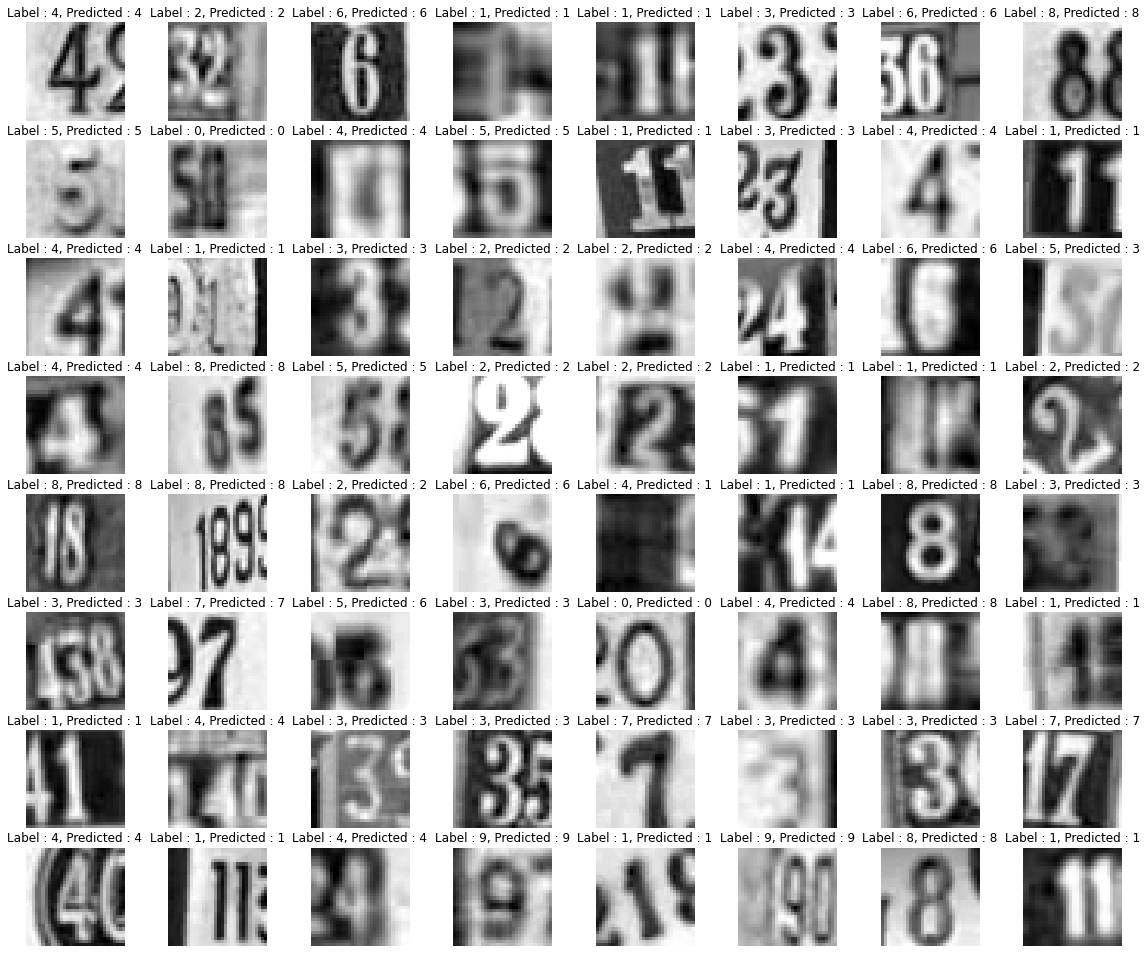

Mean precision on this batch : 0.953125


In [ ]:
# Test SVHN sur 1 batch d'image en affichant les résultats :
net.eval()
liste_mean = []
running_loss = 0.0
with torch.no_grad():
  for j in range(1):
    data = next(iter(test_loader_SVHN))
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    mean_precision = compute_precision(outputs, labels)
    liste_mean.append(mean_precision)

    plt.figure(figsize=(20,30))
    for i, image in enumerate(inputs):
      label_true = labels[i].item()
      label_predicted = np.argmax(outputs[i].detach().cpu().numpy())
      plt.subplot(14,8,i+1)
      plt.title(f'Label : {label_true}, Predicted : {label_predicted}')
      show_svhn(image.cpu())
      plt.axis('Off')

plt.show()
print("Mean precision on this batch :",np.array(liste_mean).mean())

Sur le dataset SVHN, notre classifieur a un score de 95% en moyenne sur 150 batch de 64 images !

Pour être encore plus précis, on pourrait aussi utiliser un R-CNN (type YOLO) pour distinguer chaque chiffre dans les images et ainsi les isoler pour avoir des données d'entrainement plus propres, avec qu'un seul chiffre par image.

Testons maintenant l'accuracy brute de notre classifieur sur les images MNIST :

In [ ]:
# Test MNIST :
net.eval()
liste_mean = []
with torch.no_grad():
  for j in range(100):
    for data_train in train_loader_MNIST:
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        # print(torch.argmax(outputs, axis=1).shape)

        liste_true, liste_pred = [], []
        for i, output in enumerate(outputs):
          label_predicted = np.argmax(output.cpu().detach().numpy())
          liste_pred.append(label_predicted)

          label_true = labels[i].item()
          liste_true.append(label_true)

        mean = (np.array(liste_true) == np.array(liste_pred)).mean()
        liste_mean.append(mean)
        break

  print(np.array(liste_mean).mean())

0.600625


Sur le Dataset MNIST, nous n'avons en moyenne que 60% des images qui sont bien labelisées : ce n'est déjà pas si mal, et l'enjeu de la suite de ce travail va alors être d'améliorer ce score de manière non supervisée.

## Analyse des différences entre SVHN et MNIST

Après cette introduction et la création d'un classifieur performant sur SVHN, nous allons dans la suite tâcher d'adapter ce classifieur pour avoir de meilleures performances sur MNSIT.

Pour y parvenir, regardons plus en détail les différences inhérentes aux 2 datasets que sont SVHN et MNIST.


- MNIST comporte des images ne comportant qu'un seul chiffre, en noir et blanc (image avec qu'une seul couche) et de taille 28x28.

- SVHN présente des images de numéros de maison pouvant donc comporter plusieurs chiffres, en couleur, et de taille 32x32.
La composante de couleur n'étant pas essentielle pour reconnaitre un chiffre, une première transformation a été de transformer les images RGB en grayscale. 
Par ailleurs, toutes les images sont redimensionnées en 32x32 quelque soit le dataset.

Nous pouvons également regarder les distributions des couleurs pour les 2 datasets :

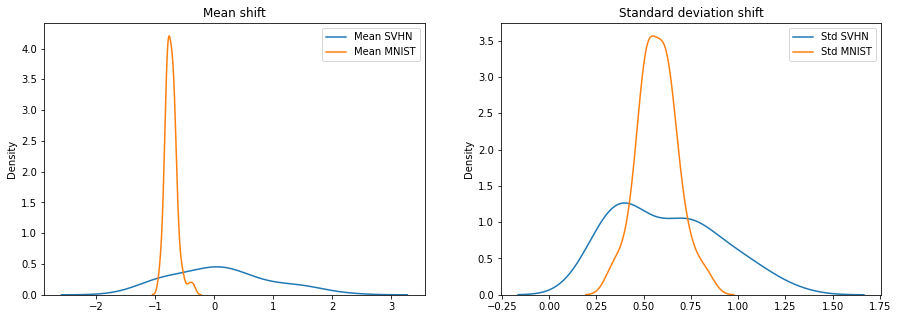

In [ ]:
images_SVHN = next(iter(train_loader_SVHN))[0]
images_MNIST = next(iter(train_loader_MNIST))[0]

# show_mnist(images_MNIST[0])
# plt.show()
# show_svhn(images_SVHN[0])

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Mean shift")
sns.kdeplot([np.mean(i) for i in np.array(images_SVHN)], label='Mean SVHN')
sns.kdeplot([np.mean(i) for i in np.array(images_MNIST)], label='Mean MNIST')
plt.legend()
plt.subplot(1,2,2)
plt.title("Standard deviation shift")
sns.kdeplot([np.std(i) for i in np.array(images_SVHN)], label='Std SVHN')
sns.kdeplot([np.std(i) for i in np.array(images_MNIST)], label='Std MNIST')
plt.legend()
plt.show()

Nous remarquons alors de grandes différences de distribution entre les 2 datasets, qui expliquent sûrement le gap d'accuracy du classifieur entre SVHN et MNIST.

En particulier, on remarque un décalage, ou "shift" entre les distributions : le dataset SVHN est bien plus complexe avec une distribution des moyennes des couleurs beaucoup plus étendue.

Nous verrons par la suite que le rôle du conditional GAN que nous utiliserons va justement d'apprendre à corriger ce shift entre les 2 datasets !

# Première idée : clustering simple sur MNIST :

Avant de se lancer dans le deep learning, testons tout d'abord un simple algorithme de clustering sur MNIST : K-means.

Essayons alors dans un premier temps de clusteriser les images MNIST (sous la forme de numpy array), pour finalement calculer un score d'homogénéité :

In [ ]:
from keras.datasets import mnist
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, y_train = X_train[:-32], y_train[:-32]

#Normalisation des array :
X_train, X_test = np.divide(X_train, 255.).reshape(X_train.shape[0], -1), np.divide(X_test, 255.).reshape(X_test.shape[0], -1)

nb_clusters = len(np.unique(y_train)) # 10 clusters

# K-means :
kmeans = KMeans(n_clusters=nb_clusters, n_init=20, n_jobs=8)
y_pred_kmeans = kmeans.fit_predict(X_train)

# Score d'homogénéité :
homogeneity_score(y_train, y_pred_kmeans)

0.48503837294942376

On remarque alors que le score est de 48% : ce n'est pas terrible.

Essayons tout de même d'améliorer ce score à l'aide d'un auto-encodeur, qui a la capacité d'apprendre à résumer des images en un vecteur latent et aussi de les débruiter :

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

# Shape of input and latent variable

n_input = 28*28

# Encoder structure
n_encoder1 = 500
n_encoder2 = 300

n_latent = 20

# Decoder structure
n_decoder2 = 300
n_decoder1 = 500

In [ ]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 0.0002, 
                   max_iter = 50, 
                   tol = 0.0000001, 
                   verbose = True)

# Pseudo labels infered by out classifier :
liste_pred2 = [int(i) for i in liste_pred]
y_train_pseudo = np.array(liste_pred2)

reg.fit(X_train,X_train)

Iteration 1, loss = 0.02009100
Iteration 2, loss = 0.01300316
Iteration 3, loss = 0.01271175
Iteration 4, loss = 0.01262986
Iteration 5, loss = 0.01258649
Iteration 6, loss = 0.01254122
Iteration 7, loss = 0.01245200
Iteration 8, loss = 0.01223373
Iteration 9, loss = 0.01186641
Iteration 10, loss = 0.01142787
Iteration 11, loss = 0.01100817
Iteration 12, loss = 0.01063641
Iteration 13, loss = 0.01030523
Iteration 14, loss = 0.01001576
Iteration 15, loss = 0.00975941
Iteration 16, loss = 0.00952917
Iteration 17, loss = 0.00932403
Iteration 18, loss = 0.00913929
Iteration 19, loss = 0.00898187
Iteration 20, loss = 0.00883111
Iteration 21, loss = 0.00869990
Iteration 22, loss = 0.00857912
Iteration 23, loss = 0.00846737
Iteration 24, loss = 0.00836260
Iteration 25, loss = 0.00826361
Iteration 26, loss = 0.00817599
Iteration 27, loss = 0.00808444
Iteration 28, loss = 0.00800291
Iteration 29, loss = 0.00792491
Iteration 30, loss = 0.00785039
Iteration 31, loss = 0.00778073
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(500, 300, 20, 300, 500),
             learning_rate='constant', learning_rate_init=0.0002, max_fun=15000,
             max_iter=50, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=1e-07, validation_fraction=0.1,
             verbose=True, warm_start=False)

Regardons comment notre Auto Encoder arrive à renconstruire une image :

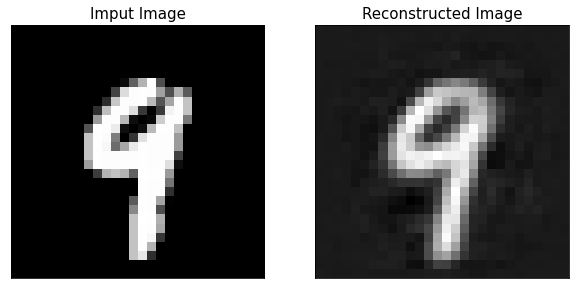

In [ ]:
idx = np.random.randint(X_test.shape[0])
x_reconst = reg.predict(X_test[idx].reshape(-1,784))

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(X_test[idx].reshape(28,28), 'gray')
plt.title('Imput Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(x_reconst.reshape(28,28), 'gray')
plt.title('Reconstructed Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()

Grâce à cet Auto Encoder, j'ai alors eu l'intuition qu'il serait intéressant de remplacer toutes les images de MNIST dans X_test par leur version encodée. En apliquant alors un K-means sur ces vecteurs, on pourrait alors avoir un meilleur score d'homogénéité !

Définissons tout d'abord les fonctions pour encoder / décoder une image :

In [ ]:
def encoder(data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)
  
def decoder(new_data):
    new_data = np.asmatrix(new_data)
    decoder2 = new_data*reg.coefs_[3] + reg.intercepts_[3]
    decoder2 = (np.exp(decoder2) - np.exp(-decoder2))/(np.exp(decoder2) + np.exp(-decoder2))

    decoder1 = decoder2*reg.coefs_[4] + reg.intercepts_[4]
    decoder1 = (np.exp(decoder1) - np.exp(-decoder1))/(np.exp(decoder1) + np.exp(-decoder1))

    reconst = decoder1*reg.coefs_[5] + reg.intercepts_[5]
    reconst = (np.exp(reconst) - np.exp(-reconst))/(np.exp(reconst) + np.exp(-reconst))

    return np.asarray(reconst)

In [ ]:
# Encodage de toutes les images : X_test --> X_test_encoded
X_test_encoded = np.zeros((X_test.shape[0], n_latent))
for i in range(X_test.shape[0]):
  X_test_encoded[i,:] = encoder(X_test[i])

In [ ]:
# Performing K-means on X_test_encoded now :
kmeans = KMeans(n_clusters=10, n_init=20, n_jobs=8)
y_pred_kmeans = kmeans.fit_predict(X_test_encoded)

# Score d'homogénéité :
print(homogeneity_score(y_test, y_pred_kmeans))

0.5470095748675271


Si le score est un peu meilleur, le K-means n'est toujours pas satisfaisant même après avoir "débruité" les images avec un auto encodeur. 

Par curiosité, regardons ce que donnent des images de SVHN passés à travers cet auto encoder :

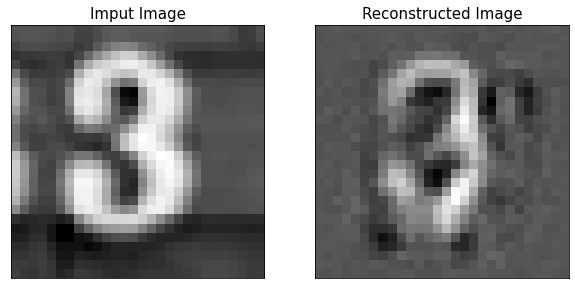

In [ ]:
# We take a random image from SVHN, rescaling it to 28*28 :
Xtest, ytest = next(iter(train_loader_SVHN))
Xtest, ytest = Xtest[0], ytest[0]
Xtest = Xtest.view(1,1,32,32)
Xtest = F.interpolate(Xtest,size=28, mode='area')
Xtest = Xtest.view(1,28,28)
Xtest = np.transpose(Xtest, (1,2,0))
Xtest = Xtest.reshape(28,28)

x_reconst = reg.predict(Xtest.reshape(-1,784))

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(Xtest.reshape(28,28), 'gray')
plt.title('Imput Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(x_reconst.reshape(28,28), 'gray')
plt.title('Reconstructed Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()

Le résultat ici est plutôt médiocre, et pour cause : la distribution de couleur (grayscale) n'est pas du tout la même pour les images de SVHN et celles de MNISt comme nous l'avons vu ! Par ailleurs, le fait qu'il y ait plusieurs chiffres dans les images de SVHN n'aide pas.

Essayons alors d'appliquer sur les images de SVHN un algorithme de transert de couleur, pour essayer d'améliorer les résultats :

In [ ]:
import numpy as np
import cv2
import argparse


# This function will return us the image stats
# We input an image in the L*a*b* color space and it returns
# a tuple of mean and std for L*, a* and b* respectively.
def image_stats(image):
    # Compute the mean and standard deviation of each channel
    (l, a, b) = cv2.split(image)
    (l_mean, l_std) = (l.mean(), l.std())
    (a_mean, a_std) = (a.mean(), a.std())
    (b_mean, b_std) = (b.mean(), b.std())

    # return the color statistics
    return (l_mean, l_std, a_mean, a_std, b_mean, b_std)


# This function will perform color transfer from one input image (source)
# onto another input image (destination)
def color_transfer(source, destination):
    # Convert the images from the RGB to L*a*b* color space, being
    # sure to utilizing the floating point data type (note: OpenCV
    # expects floats to be 32-bit, so use that instead of 64-bit)
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    destination = cv2.cvtColor(destination, cv2.COLOR_BGR2LAB).astype("float32")

    # Compute color statistics for the source and destination images
    (l_mean_src, l_std_src, a_mean_src, a_std_src, b_mean_src, b_std_src) = image_stats(source)
    (l_mean_dest, l_std_dest, a_mean_dest, a_std_dest, b_mean_dest, b_std_dest) = image_stats(destination)

    # Subtract the means from the destination image
    (l, a, b) = cv2.split(destination)
    l -= l_mean_dest
    a -= a_mean_dest
    b -= b_mean_dest

    # Scale by the standard deviations
    l = (l_std_dest / l_std_src) * l
    a = (a_std_dest / a_std_src) * a
    b = (b_std_dest / b_std_src) * b

    # Add in the source mean
    l += l_mean_src
    a += a_mean_src
    b += b_mean_src

    # Clip the pixel intensities to [0, 255] if they fall outside this range
    l = np.clip(l, 0, 255)
    a = np.clip(a, 0, 255)
    b = np.clip(b, 0, 255)

    # Merge the channels together and convert back to the RGB color space,
    # being sure to utilize the 8-bit unsigned integer data type.
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)

    # Return the color transferred image
    return transfer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Color Transfer :')

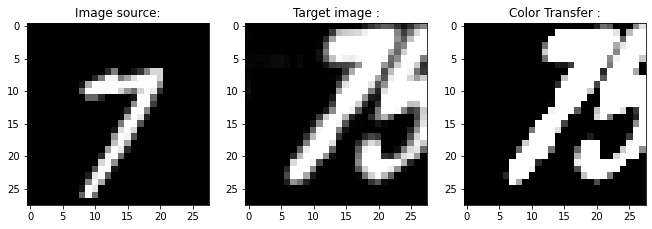

In [ ]:
from PIL import Image
zero = np.zeros((28,28,3))
ind = random.randint(0,X_test.shape[0])
zero[:,:,0] = X_test[ind].reshape(28,28)
zero[:,:,1] = X_test[ind].reshape(28,28)
zero[:,:,2] = X_test[ind].reshape(28,28)

image_source = np.float32(zero)


Xtest, ytest = next(iter(train_loader_SVHN))
Xtest, ytest = Xtest[0], ytest[0]
Xtest = Xtest.view(1,1,32,32)
Xtest = F.interpolate(Xtest,size=28, mode='area')
Xtest = Xtest.view(1,28,28)
Xtest = np.transpose(Xtest, (1,2,0))
Xtest = Xtest.reshape(28,28)

zero1 = np.zeros((28,28,3))
zero1[:,:,0] = np.array(Xtest).reshape(28,28)
zero1[:,:,1] = np.array(Xtest).reshape(28,28)
zero1[:,:,2] = np.array(Xtest).reshape(28,28)

image_target = np.float32(zero1)
#image_target = (image_target - image_target.min()) / (image_target.max() - image_target.min())

#Color transfer :
color_transfered = color_transfer(image_source, image_target)[:,:,0]


#Color transfer :
plt.figure(figsize=(15,20))
plt.subplot(1,4,1)
plt.imshow(image_source, cmap='gray')
plt.title("Image source:")

plt.subplot(1,4,2)
plt.imshow(image_target, cmap='gray')
plt.title("Target image :")

plt.subplot(1,4,3)
plt.imshow(color_transfered, cmap='gray')
plt.title("Color Transfer :")

Ce type de transfert de couleurs permet dans de nombreux cas d'améliorer les images SVHN d'input : les couleurs sont plus ressemblantes.

Néanmoins, ce transfert de couleurs ne permet pas de convertir les images de SVHN pour faire apparaitre les chiffres blancs sur un fond noir.

### Pistes d'améloration sur cette technique :

On pourrait par la suite améliorer le transfert de couleur de SVHN vers MNIST en écrivant un algorithme isolant le chiffre principal, et le colorant en blanc sur un fond noir.

En entrainant un classifieur sur ces images de SVHN annotées et transformées, on aurait alors une précision bien meilleure que 60% !

Le temps étant limité, nous allons alors nous concentrer par la suite sur la technique plus avancée et prometteuse avec le conditional GAN :

# Adaptation de domaine avec un C-GAN :

Dans cette partie, nous allons nous inspirer du papier https://arxiv.org/pdf/2001.02950.pdf pour améliorer les performances du classifieur sur MNIST.

Pourquoi utiliser un conditional-GAN ?

Le c-GAN est utilisé en adaptation de domaine non supervisé pour ses propriétés de robustesse aux bruits : uniformes, mais aussi au shift que nous avions vu précédemment !

La première partie consiste à pré-entrainer un c-GAN avec les images de MNISt labélisées par notre classifieur "C" entrainé sur SVHN. Etant précis au départ à 60% sur MNIST, les mauvaises pseudo-labélisations de C peuvent alors être modélisées pour le c-GAN comme des labels bruités et décalés ("shift noise labels").

Le c-GAN est alors pré-entrainé de manière traditionnelle (Discriminateur + Générateur), mis à part le fait que le Discriminateur s'entraine à distinguer des images réelles de MNISt avec des labels inférés par C.

le c-GAN est alors entrainé par le jeu du "Min Max" formulé par Goodfellow et al. : `minθD maxθG LGAN = Ex∼px [− log D(x; θD)] (1) + Ez∼pz [− log(1 − D(G(z; θG); θD))]`




In [ ]:
C,H,W = 1, 32, 32

# Initialisation des poids :
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0.0)

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, C, 4, 2, 1)


    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x

class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(C, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)


    # def forward(self, input):
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))
        return x

In [ ]:
# Fonction de loss
adversarial_loss = torch.nn.BCELoss()

# Init du Generator et Discriminator
generator = Generator()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialisation des poids
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
lr = 0.0001
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# optimizer_G = torch.optim.SGD(generator.parameters(), lr=lr)
# optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=lr)

## Pré-entrainement du GAN sur MNIST avec les annotations issues du classifieur C ("net") :

In [ ]:
def plotGeneratedImages(generatedImages,dim=(2, 5), figsize=(7, 4)):
    generatedImages=generatedImages.detach().cpu().numpy()
    print("\n","Testing a batch of images from the generator:")
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.title(i)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_image_batch():
    gen_y = torch.zeros(Batch_Size, N_Class).cuda()
    labels = torch.arange(64).to(device)%10
    gen_y = Variable(gen_y.scatter_(1, labels.view(batch_size, 1), 1).view(batch_size, N_Class,1,1).cuda())
    z = Variable(torch.randn((batch_size, latent_dim,1,1)).cuda())
    with torch.no_grad():
      generated = generator(z, gen_y).view(-1,C,H,W)
    generated = generated[:10]
    plotGeneratedImages(generated.view(generated.size(0), 1, 32, 32))

# Parameters :
Batch_Size = batch_size
N_Class = 10
img_size = 32
latent_dim = 100

[Epoch 0/3] [Batch 0/937] [D loss: 1.767812] [G loss: 2.920630] [C accuracy: 0.687500]
[Epoch 0/3] [Batch 100/937] [D loss: 0.037124] [G loss: 7.113678] [C accuracy: 0.593750]
[Epoch 0/3] [Batch 200/937] [D loss: 0.135958] [G loss: 2.211516] [C accuracy: 0.718750]
[Epoch 0/3] [Batch 300/937] [D loss: 0.026082] [G loss: 4.684068] [C accuracy: 0.484375]
[Epoch 0/3] [Batch 400/937] [D loss: 0.050728] [G loss: 4.663141] [C accuracy: 0.515625]
[Epoch 0/3] [Batch 500/937] [D loss: 0.003840] [G loss: 8.939497] [C accuracy: 0.578125]
[Epoch 0/3] [Batch 600/937] [D loss: 0.004480] [G loss: 7.546880] [C accuracy: 0.593750]
[Epoch 0/3] [Batch 700/937] [D loss: 0.360052] [G loss: 2.949398] [C accuracy: 0.593750]
[Epoch 0/3] [Batch 800/937] [D loss: 0.020140] [G loss: 4.139683] [C accuracy: 0.625000]
[Epoch 0/3] [Batch 900/937] [D loss: 0.006428] [G loss: 8.828619] [C accuracy: 0.671875]

 Testing a batch of images from the generator:


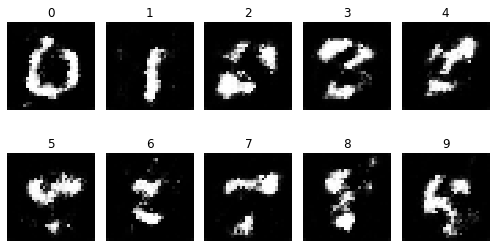

[Epoch 1/3] [Batch 0/937] [D loss: 0.000028] [G loss: 11.486083] [C accuracy: 0.609375]
[Epoch 1/3] [Batch 100/937] [D loss: 0.001666] [G loss: 10.306608] [C accuracy: 0.671875]
[Epoch 1/3] [Batch 200/937] [D loss: 0.002419] [G loss: 5.162982] [C accuracy: 0.609375]
[Epoch 1/3] [Batch 300/937] [D loss: 0.164601] [G loss: 2.631603] [C accuracy: 0.593750]
[Epoch 1/3] [Batch 400/937] [D loss: 0.579233] [G loss: 2.479795] [C accuracy: 0.578125]
[Epoch 1/3] [Batch 500/937] [D loss: 0.071729] [G loss: 3.508190] [C accuracy: 0.609375]
[Epoch 1/3] [Batch 600/937] [D loss: 0.000127] [G loss: 9.079241] [C accuracy: 0.546875]
[Epoch 1/3] [Batch 700/937] [D loss: 0.000015] [G loss: 12.545261] [C accuracy: 0.656250]
[Epoch 1/3] [Batch 800/937] [D loss: 0.000289] [G loss: 8.451802] [C accuracy: 0.640625]
[Epoch 1/3] [Batch 900/937] [D loss: 0.000150] [G loss: 10.318821] [C accuracy: 0.578125]

 Testing a batch of images from the generator:


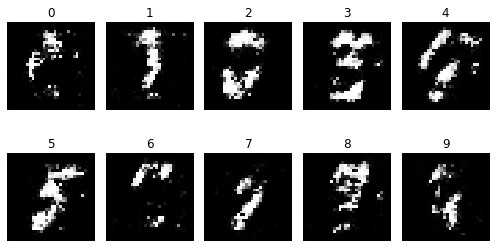

[Epoch 2/3] [Batch 0/937] [D loss: 0.066172] [G loss: 1.820107] [C accuracy: 0.703125]
[Epoch 2/3] [Batch 100/937] [D loss: 0.133061] [G loss: 3.080097] [C accuracy: 0.531250]
[Epoch 2/3] [Batch 200/937] [D loss: 0.000770] [G loss: 12.607733] [C accuracy: 0.578125]
[Epoch 2/3] [Batch 300/937] [D loss: 0.034497] [G loss: 4.434967] [C accuracy: 0.546875]
[Epoch 2/3] [Batch 400/937] [D loss: 0.004882] [G loss: 6.904351] [C accuracy: 0.578125]
[Epoch 2/3] [Batch 500/937] [D loss: 0.056282] [G loss: 3.239820] [C accuracy: 0.609375]
[Epoch 2/3] [Batch 600/937] [D loss: 0.091499] [G loss: 5.507154] [C accuracy: 0.656250]
[Epoch 2/3] [Batch 700/937] [D loss: 0.000008] [G loss: 13.445408] [C accuracy: 0.578125]
[Epoch 2/3] [Batch 800/937] [D loss: 0.004181] [G loss: 5.942769] [C accuracy: 0.578125]
[Epoch 2/3] [Batch 900/937] [D loss: 0.007176] [G loss: 9.858015] [C accuracy: 0.703125]

 Testing a batch of images from the generator:


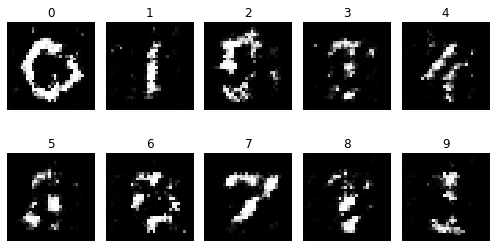

In [ ]:
epochs = 3
dataloader = train_loader_MNIST
net.eval()

for epoch in range(epochs):

    for i, (imgs, true_labels) in enumerate(dataloader):
        
        # On remplace les vrais labels (qui sont en réalité inconnus) par les labels prédits par C :
        with torch.no_grad():
          out = net(imgs.cuda())
          labels = torch.argmax(out, axis=1).cuda()
          acc  = np.mean(np.array(labels.cpu()==true_labels))

          ## Check avec vrais labels MNISt :
          # acc = 0
          # labels = true_labels.cuda()

        # Adversarial ground truths
        valid = Variable(torch.ones(Batch_Size).cuda(), requires_grad=False)
        fake = Variable(torch.zeros(Batch_Size).cuda(), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.FloatTensor).cuda())

        real_y = torch.zeros(Batch_Size, N_Class).cuda()
        real_y = real_y.scatter_(1, labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class, 1, 1).contiguous()
        real_y = Variable(real_y.expand(-1, -1, img_size, img_size).cuda())

        # Sample noise and labels as generator input
        noise = Variable(torch.randn((Batch_Size, latent_dim,1,1)).cuda())
        gen_labels = (torch.rand(Batch_Size, 1) * N_Class).type(torch.LongTensor)
        gen_y = torch.zeros(Batch_Size, N_Class)
        gen_y = Variable(gen_y.scatter_(1, gen_labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class,1,1).cuda())
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Loss for real images
        d_real_loss = adversarial_loss(discriminator(real_imgs, real_y).squeeze(), valid)
        # Loss for fake images
        gen_imgs = generator(noise, gen_y)
        gen_y_for_D = gen_y.view(Batch_Size, N_Class, 1, 1).contiguous().expand(-1, -1, img_size, img_size)

        d_fake_loss = adversarial_loss(discriminator(gen_imgs.detach(),gen_y_for_D).squeeze(), fake)
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)
        # if i%30==0:
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        g_loss = adversarial_loss(discriminator(gen_imgs,gen_y_for_D).squeeze(), valid)
        g_loss.backward(retain_graph=True)
        optimizer_G.step()

        if i%100==0 :
          print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C accuracy: %f]" % (epoch, epochs, i, len(dataloader),
                                                            d_loss.data.cpu(), g_loss.data.cpu(), acc))
          #plot_image_batch()
          
    plot_image_batch()

In [ ]:
# Save pretrained weights :
# Info : V2 with gen_y = gen_y.view(), v3 with gen_y = labels.view(), v4=test
torch.save(generator.state_dict(), os.path.join(path_save, 'generator_pretrainedV6.pth'))
torch.save(discriminator.state_dict(), os.path.join(path_save, 'discriminator_pretrainedV6.pth'))

In [ ]:
# Load pretrained weights :
generator.load_state_dict(torch.load(os.path.join(path_save, 'generator_pretrainedV5.pth')))
discriminator.load_state_dict(torch.load(os.path.join(path_save, 'discriminator_pretrainedV5.pth')))

<All keys matched successfully>

Testing with the pretrained generator :

In [ ]:
def plotGeneratedImages_8x8(generatedImages,dim=(8, 8), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print("\n",generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()

True labels : tensor([7, 9, 4, 7, 2, 2, 6, 2, 7, 3, 7, 7, 8, 0, 1, 1, 4, 7, 5, 5, 2, 7, 2, 5,
        5, 0, 1, 9, 1, 6, 0, 4, 8, 8, 3, 8, 3, 1, 9, 1, 0, 5, 7, 2, 0, 3, 8, 9,
        0, 7, 7, 1, 5, 1, 9, 8, 7, 7, 6, 8, 9, 5, 4, 5])

 Classified labels : tensor([7, 2, 9, 7, 2, 2, 4, 2, 3, 3, 7, 7, 8, 2, 1, 4, 2, 3, 5, 5, 4, 7, 2, 5,
        5, 0, 4, 2, 1, 2, 0, 4, 8, 8, 3, 8, 3, 7, 3, 1, 2, 4, 7, 3, 4, 3, 3, 9,
        2, 7, 7, 4, 5, 1, 7, 8, 7, 7, 6, 8, 5, 5, 3, 5], device='cuda:0')

 (64, 1, 32, 32)


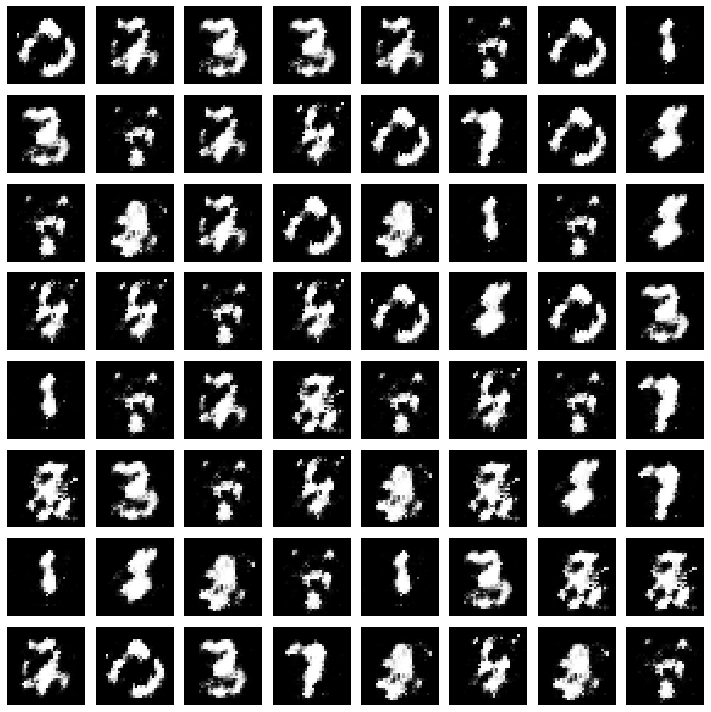

In [ ]:
# Testing the pretrained generator :
with torch.no_grad():
  # images, true_labels = next(iter(train_loader_MNIST))
  # labels = torch.argmax(net(images.cuda()), axis=1).cuda()
  # true_labels = true_labels.cuda()

  print("True labels :",true_labels)
  print("\n Classified labels :", labels)

  test_z = Variable(torch.randn((Batch_Size, latent_dim,1,1)).cuda())
  gen_labels = (torch.rand(Batch_Size, 1) * N_Class).type(torch.LongTensor).to(device)
  gen_y = torch.zeros(Batch_Size, N_Class).cuda()
  gen_y = Variable(gen_y.scatter_(1, gen_labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class,1,1).cuda())
  generated = generator(test_z, gen_y)
  plotGeneratedImages_8x8(generated.view(generated.size(0), 1, 32, 32))

Malgré beaucoup d'efforts, les images du cGAN pré-entrainé ne sont pas très belles.

Cela se voit dès l'entrainement, où la loss du discriminateur descend très rapidement tandis que celle du générateur augmente.

Avec les vrais labels de MNIST, je n'ai pas eu ce comportement : c'est donc le "shift noise" des labels inférés par le classifieur qui est à l'origine de l'instabilité d'entrainement du GAN.

Pour contrer cela et améliorer les performances, j'ai testé plusieurs stratégies :
- Jouer sur les hyperparamètres (learning rate surtout, momentum etc...)
- Tester des loss différentes
- Entrainer le discriminateur toutes les n-itérations
- Ne garder que les labels prédits au-delà d'un certain poucentage de confiance
- Tester différents optimizers (Adam, SGD)

Peut-être qu'il me manque quelque chose que je n'ai pas testé, et je serais très intéressé d'avoir votre retour si vous voyez comment améliorer le pré-entrainement !


**Pour la suite, la mauvaise qualité des images ne m'a pas porté préjudice car j'ai pu re-entrainer le classifieur C pour arriver à une précision de 96% sur MNIST :**

## Re-entrainement du classifieur C avec le c-GAN pre-entrainé

Dans cette partie, nous devons alors :

- Génerer des image à partir d'un bruit (latent) et de labels aléatoires
- Classifier ces images générées avec notre classifieur C 
- Mettre à jour C 
- Mettre à jour le Discriminateur (avec de vraies images de MNISt labélisées par C) et le Generateur, de la même façon que lors du pré-entrainement

Ainsi, en alternant les étapes d'entrainement de C et de (G,D), on va progressivement réduire l'asymétrie du "shift noise" initial.

Nous allons ainsi apprendre à notre générateur à générer des images de plus en plus ressemblantes à celles de MNIST, et donc au classifieur d'améliorer sa précision sur MNIST.

In [ ]:
# For classifier :
torch.cuda.empty_cache()

#Loading state dict :
# Load model weights :
net.load_state_dict(torch.load(os.path.join(path_save, 'Gray_OKV2.pth')))

#Criterion and optimizer :
lr = 1e-6
criterion_C = nn.CrossEntropyLoss()
optimizer_C = optim.Adam(net.parameters(), lr=lr)

In [ ]:
# For cGAN :
#Loading pretrained weights :
generator.load_state_dict(torch.load(os.path.join(path_save, 'generator_pretrainedV4.pth')))
discriminator.load_state_dict(torch.load(os.path.join(path_save, 'discriminator_pretrainedV4.pth')))

#Criterion and optimizer :
lr = 0.0001
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Function to evauate classifier on MNISt :
def evaluate_C_MNIST():
  net.eval()
  liste_mean = []
  with torch.no_grad():
    for j in range(30):
      for data_train in train_loader_MNIST:
          inputs, labels = data_train
          inputs, labels = inputs.to(device), labels.to(device)
          
          outputs = net(inputs)
          # print(torch.argmax(outputs, axis=1).shape)

          liste_true, liste_pred = [], []
          for i, output in enumerate(outputs):
            label_predicted = np.argmax(output.cpu().detach().numpy())
            liste_pred.append(label_predicted)

            label_true = labels[i].item()
            liste_true.append(label_true)

          mean = (np.array(liste_true) == np.array(liste_pred)).mean()
          liste_mean.append(mean)
          break

    return(np.array(liste_mean).mean())

In [ ]:
epochs_train2 = 5
dataloader = train_loader_MNIST

for epoch in range(epochs_train2):
    for i, (imgs, test) in enumerate(dataloader):

        ## STEP 1 :
        # Sample noise and labels as generator input
        noise = Variable(torch.randn((Batch_Size, latent_dim,1,1)).cuda())
        gen_labels = (torch.rand(Batch_Size, 1) * N_Class).type(torch.LongTensor)
        gen_y = torch.zeros(Batch_Size, N_Class)
        gen_y = Variable(gen_y.scatter_(1, gen_labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class,1,1).cuda())

        # generate Data with G :
        gen_imgs = generator(noise, gen_y)

        # Classify 'em with C
        #pseudo_true_labels = torch.argmax(net(gen_imgs.cuda()), axis=1).to(device)
        pseudo_true_labels = net(gen_imgs.cuda()).to(device)
        
        #Update C :
        optimizer_C.zero_grad()
        gen_labels = gen_labels.view(batch_size).to(device)
        # optimizer zero grad
        loss_C = criterion_C(pseudo_true_labels, gen_labels)
        loss_C.to(device)
        loss_C.backward(retain_graph=True)
        optimizer_C.step()


        ##STEP 2 : Update G & D :

        # On remplace les vrais labels (qui sont en réalité inconnus) par les labels prédits par C :
        with torch.no_grad():
          labels = torch.argmax(net(imgs.cuda()), axis=1).cuda()

        # Adversarial ground truths
        valid = Variable(torch.ones(Batch_Size).cuda(), requires_grad=False)
        fake = Variable(torch.zeros(Batch_Size).cuda(), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.FloatTensor).cuda())

        real_y = torch.zeros(Batch_Size, N_Class).cuda()
        real_y = real_y.scatter_(1, labels.view(Batch_Size, 1), 1).view(Batch_Size, N_Class, 1, 1).contiguous()
        real_y = Variable(real_y.expand(-1, -1, img_size, img_size).cuda())

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Loss for real images
        d_real_loss = adversarial_loss(discriminator(real_imgs, real_y).squeeze(), valid)
        # Loss for fake images
        #gen_imgs = generator(noise, gen_y)
        gen_y_for_D = gen_y.view(Batch_Size, N_Class, 1, 1).contiguous().expand(-1, -1, img_size, img_size)

        d_fake_loss = adversarial_loss(discriminator(gen_imgs.detach(),gen_y_for_D).squeeze(), fake)
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        g_loss = adversarial_loss(discriminator(gen_imgs,gen_y_for_D).squeeze(), valid)
        g_loss.backward(retain_graph=True)
        optimizer_G.step()

        if i%20==0 :
          evaluate_C_MNIST()
          print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss: %f] [SCORE C MNIST: %f]" % (epoch, epochs_train2, i, len(dataloader),
                                                            d_loss.data.cpu(), g_loss.data.cpu(), loss_C.data.cpu(), evaluate_C_MNIST()))

[Epoch 0/5] [Batch 0/937] [D loss: 1.159832] [G loss: 0.688974] [C loss: 1.894840] [SCORE C MNIST: 0.627083]
[Epoch 0/5] [Batch 20/937] [D loss: 0.986990] [G loss: 1.212934] [C loss: 1.911818] [SCORE C MNIST: 0.632812]
[Epoch 0/5] [Batch 40/937] [D loss: 1.104256] [G loss: 1.026414] [C loss: 1.880094] [SCORE C MNIST: 0.631771]
[Epoch 0/5] [Batch 60/937] [D loss: 0.270977] [G loss: 3.665839] [C loss: 1.893879] [SCORE C MNIST: 0.668229]
[Epoch 0/5] [Batch 80/937] [D loss: 0.259379] [G loss: 2.196231] [C loss: 1.872519] [SCORE C MNIST: 0.659375]
[Epoch 0/5] [Batch 100/937] [D loss: 0.414026] [G loss: 2.037653] [C loss: 1.885621] [SCORE C MNIST: 0.665104]
[Epoch 0/5] [Batch 120/937] [D loss: 2.053314] [G loss: 0.767419] [C loss: 1.882303] [SCORE C MNIST: 0.676042]
[Epoch 0/5] [Batch 140/937] [D loss: 0.237890] [G loss: 1.440668] [C loss: 1.845259] [SCORE C MNIST: 0.660417]
[Epoch 0/5] [Batch 160/937] [D loss: 0.145899] [G loss: 3.364015] [C loss: 1.830119] [SCORE C MNIST: 0.669792]
[Epoch 

Saving C weights :

In [ ]:
# torch.save(net.state_dict(), os.path.join(path_save, 'C_fullyTrained.pth'))

In [ ]:
net.load_state_dict(torch.load(os.path.join(path_save, 'C_fullyTrained.pth')))

<All keys matched successfully>

Testing again on MNIST dataset with newly trained classifier C :

In [ ]:
# Test MNIST :
net.eval()
liste_mean = []
with torch.no_grad():
  for j in range(50):
    for data_train in train_loader_MNIST:
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        # print(torch.argmax(outputs, axis=1).shape)

        liste_true, liste_pred = [], []
        for i, output in enumerate(outputs):
          label_predicted = np.argmax(output.cpu().detach().numpy())
          liste_pred.append(label_predicted)

          label_true = labels[i].item()
          liste_true.append(label_true)

        mean = (np.array(liste_true) == np.array(liste_pred)).mean()
        liste_mean.append(mean)
        break

  print(np.array(liste_mean).mean())

0.960625


**Conlusion : en suivant la méthode du "Generative Pseudo-label Refinement for Unsupervised Domain Adaptation", j'ai alors reussi à faire monter l'accuracy du classifieur C à 96% sur MNIST !**

Celà a été possible grâce aux propriétées du c-GAN découvertes par Pietro Morerio et al., de robustesse du c-GAN aux shift noise, c'est-à-dire au bruit dû à une mauvaise labélisation.

J'imagine alors que cela  peut marcher à partir du moment où notre classifieur C initial arrive à labéliser correctement une partie des images MNIST (60% dans notre cas), en se trompant de manière uniforme sur tous les chiffres. le c-GAN arrive alors à faire la part des choses en ne se laissant pas influencer par ces mauvaises labélisations, par un effet de moyennage.

Mais qu'en est-il si le classifieur se trompait tout le temps sur la même classe ?

